# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [2]:
# import needed packages

import numpy as np
from skimage import exposure,filters,segmentation,morphology,measure,color,data,feature,draw,transform
from skimage.measure import ransac, EllipseModel
%matplotlib inline
import matplotlib.pyplot as plt



### Inspect the image, adjust exposure

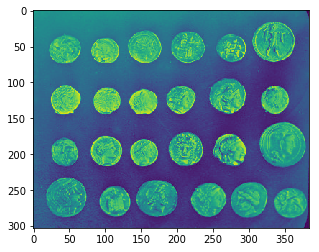

In [3]:
img = data.coins()
plt.imshow(img)


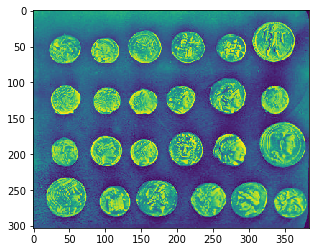

In [4]:
img_eq = exposure.equalize_adapthist(img)
plt.imshow(img_eq)

### Create binary image, clear the border, binary open and close the image

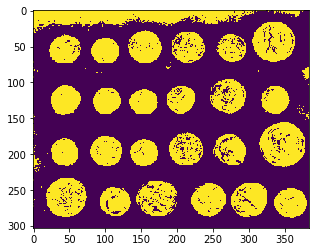

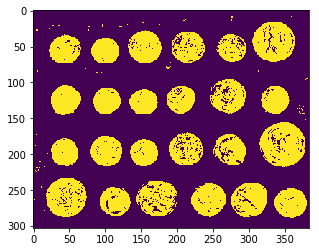

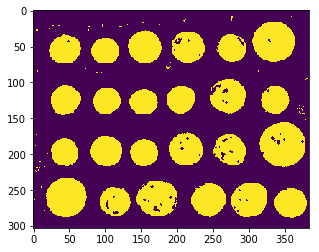

In [5]:
thresh = filters.threshold_otsu(img_eq)
mask = img_eq > thresh
img_no_border = segmentation.clear_border(mask)
img_open = morphology.closing(img_no_border)

img_closed = morphology.closing(img_open)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(img_no_border)
plt.figure()
plt.imshow(img_closed)


### Remove small objects from the background, and fill small holes in the coins

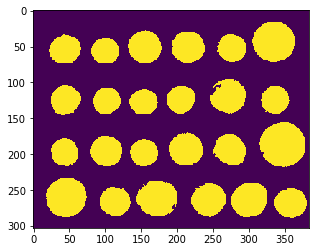

In [6]:


img_no_holes = morphology.remove_small_objects(img_closed, 20)


structure_element = morphology.disk(1)

seed = np.copy(img_closed)
seed[1:-1, 1:-1] = img_no_holes.max()
mask = img_no_holes

img_filled = morphology.reconstruction(seed,mask,method='erosion',selem=structure_element)
plt.figure()
plt.imshow(img_filled)

### Label all regions, check that we find 24 regions

24


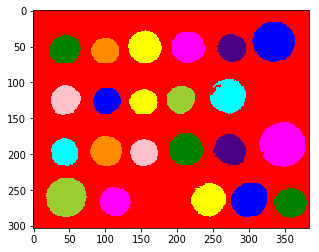

In [7]:
labels, num = measure.label(img_filled,return_num=True,connectivity=2)
label_img = color.label2rgb(labels)

plt.figure()
plt.imshow(label_img)
'''regions = measure.regionprops(labels)
areas = [r.area for r in regions]
ecc = [r.eccentricity for r in regions]'''


print(num)



### Find the edges of the coins, use RANSAC to fit an ellipse to each coin, calculate area and eccentricity from this fit

/Users/cwfink/anaconda3/envs/bootcamp-env/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


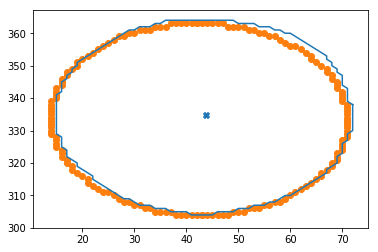

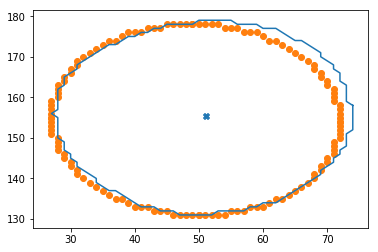

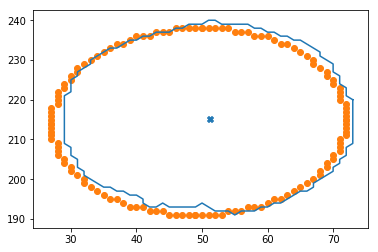

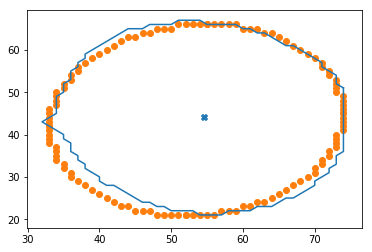

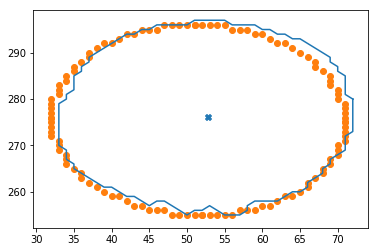

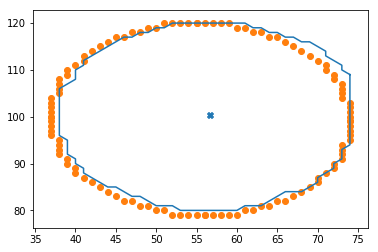

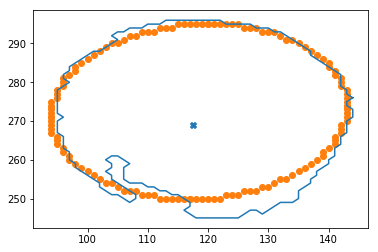

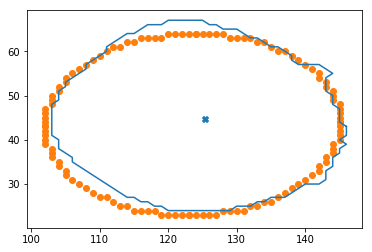

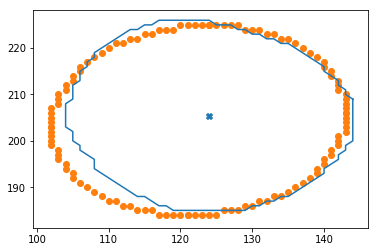

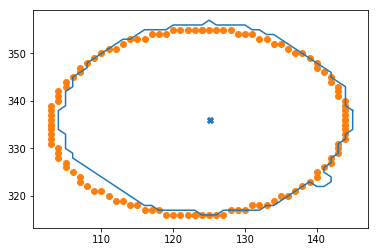

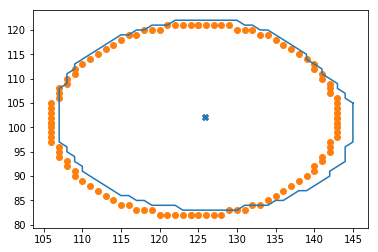

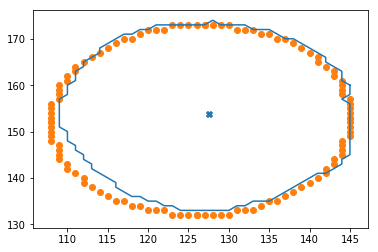

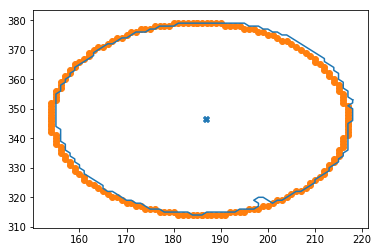

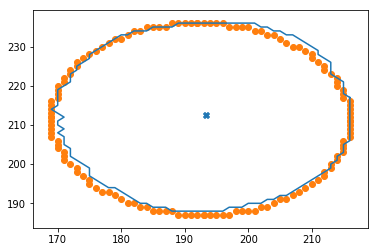

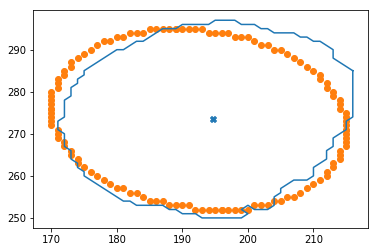

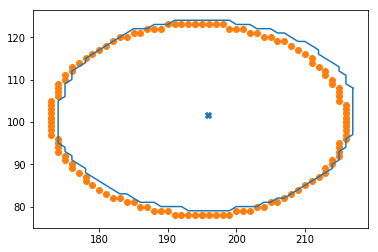

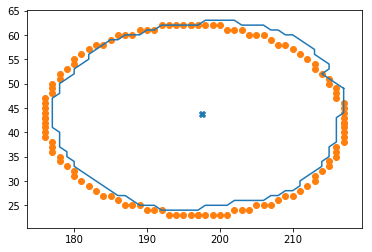

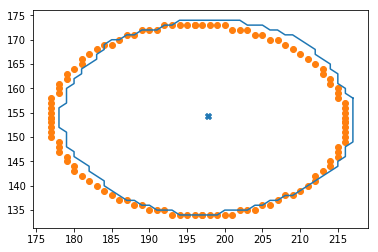

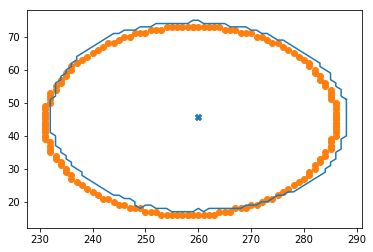

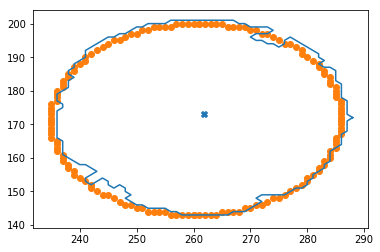

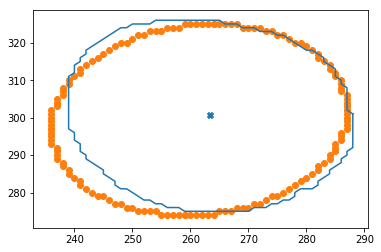

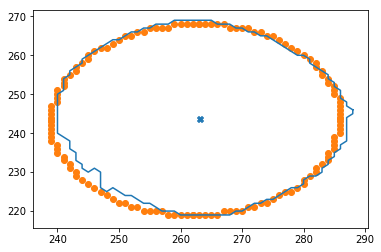

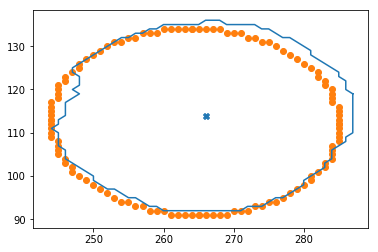

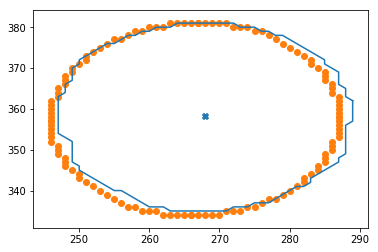

In [8]:

edges = measure.find_contours(img_filled,level = 0)
#x = np.ones(shape = len(edges))
#y = np.ones(shape = len(edges))
coin_properties = []


    
for coin in edges:

    model,inliers = ransac(coin, EllipseModel , min_samples=4,residual_threshold=2)
    xc, yc, a, b, theta = model.params
    ellipse = draw.ellipse_perimeter(int(xc), int(yc), int(a), int(b), theta)
    
    Area = np.pi*a*b
    if b < a:
        eccent = np.sqrt(1-(b/a)**2)
    elif b > a: 
        eccent = np.sqrt(1-(a/b)**2)
        
    x = coin[:,0]
    y = coin[:,1]
    center = [np.mean(x),np.mean(y)]
        
    data = {'location' : center,
            'Area' : Area,
            'eccentricity' : eccent,
            'ellipse' : ellipse}
    coin_properties.append(data)
    
    plt.figure()
    plt.plot(x,y)
    plt.scatter(center[0],center[1],marker='X')
    plt.scatter(ellipse[0],ellipse[1])
    





### Plot ellipses and info text on top of original image

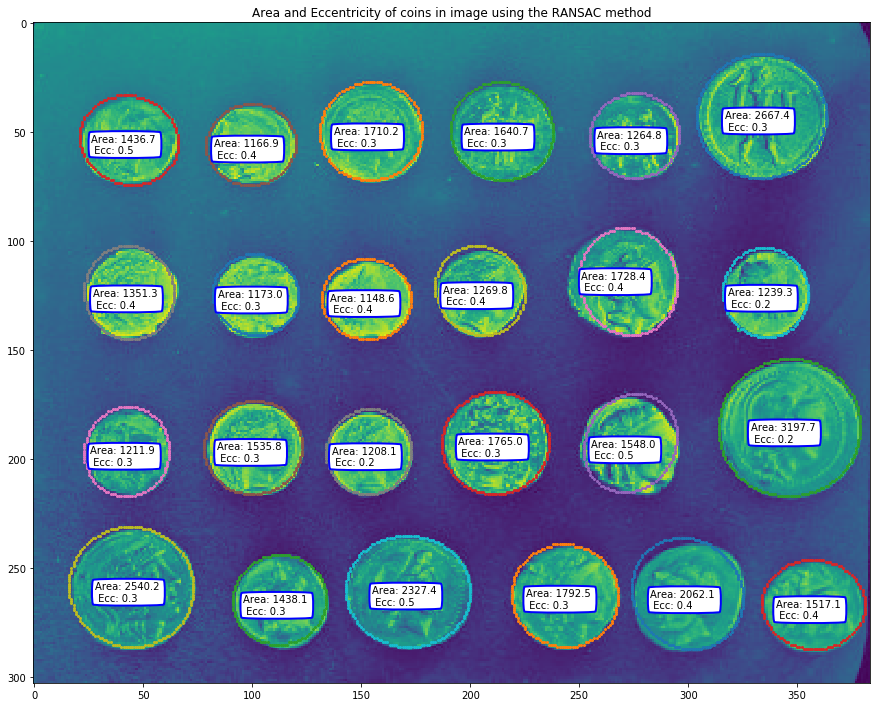

In [9]:
coin_properties[0]['ellipse']
plt.figure(figsize=(15,15))
plt.title('Area and Eccentricity of coins in image using the RANSAC method')
plt.imshow(img)
for coin in coin_properties:
    x = coin['ellipse'][1]
    y = coin['ellipse'][0]
    
    plt.scatter(x,y,marker='o',s=4)
    plt.annotate('Area: {} \n Ecc: {}'.format(round(coin['Area'],1),round(coin['eccentricity'],1)) \
                 , xy = (coin['location'][::-1][0]-18,coin['location'][::-1][1]+5) \
                 , bbox = dict(boxstyle="round4,pad=0.3", fc="w", ec="b", lw=2))

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

# Note, the majority of the code was copied from the given link to the skimage tutorial 

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.color import rgb2gray, gray2rgb
from skimage import exposure
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.feature import plot_matches
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.measure import label
from skimage.graph import route_through_array

In [11]:
# Helper function to plot images side by side
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

### Import images and convert to grayscale

I've uploaded 3 'amazing' images of my appartment complex as seen from my patio, as these were the only pictures I could make work!.... I tried to make a nice panorama of the city, but I was unable to make it work... Also, I tried to make a funny panorama with my daugher in it, but the algorithm kept mapping parts of her body to the carpet, this made for very strange combined images....

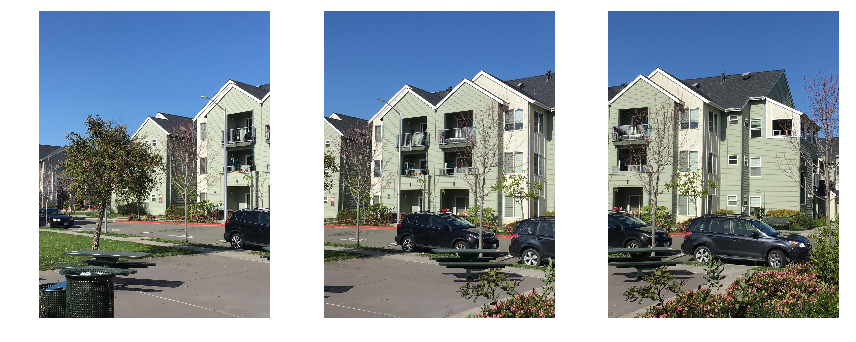

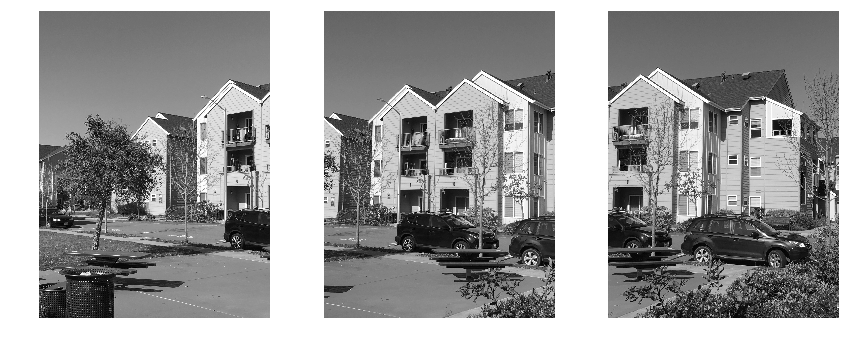

In [12]:
pano_imgs = io.ImageCollection('images/IMG_*')
compare(*pano_imgs, figsize=(12, 10))
pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]
compare(pano0, pano1, pano2, figsize=(12, 10))

### Detect interesting features, and map the features between the 3 images

In [13]:

orb = ORB(n_keypoints=5000, fast_threshold=.02)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)




### Visualize the matches

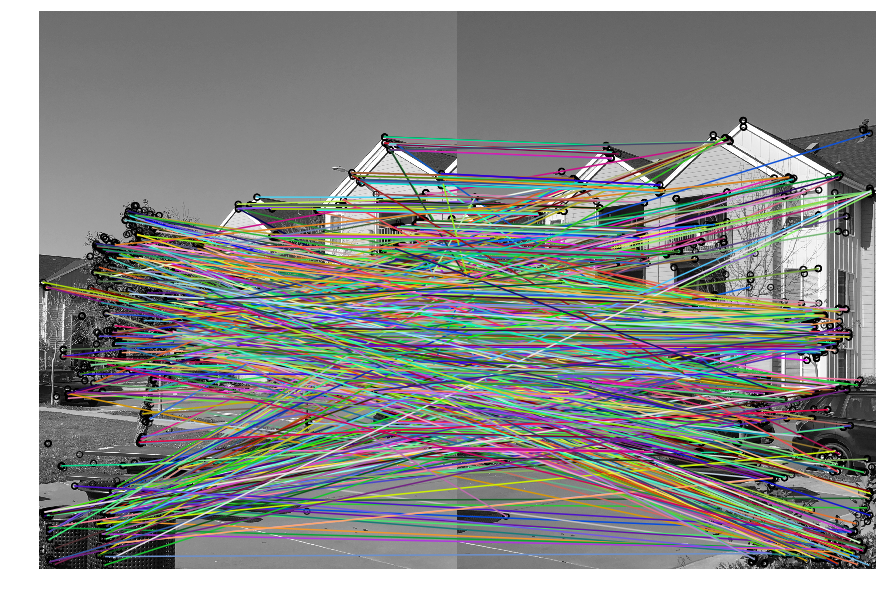

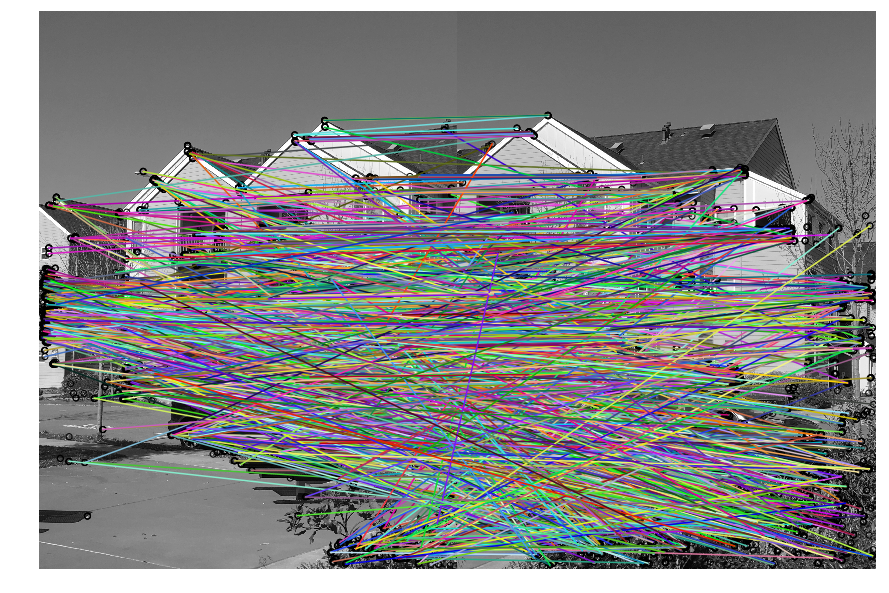

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
ax.axis('off');

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
ax.axis('off');

### Use RANSAC to elimiate the outlier matches

In [15]:
# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

### Visualize inlier matches

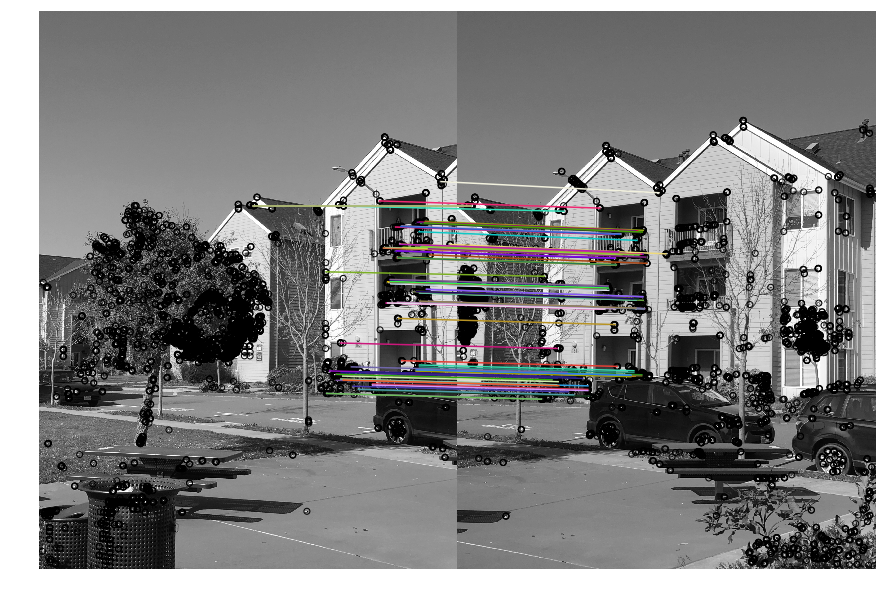

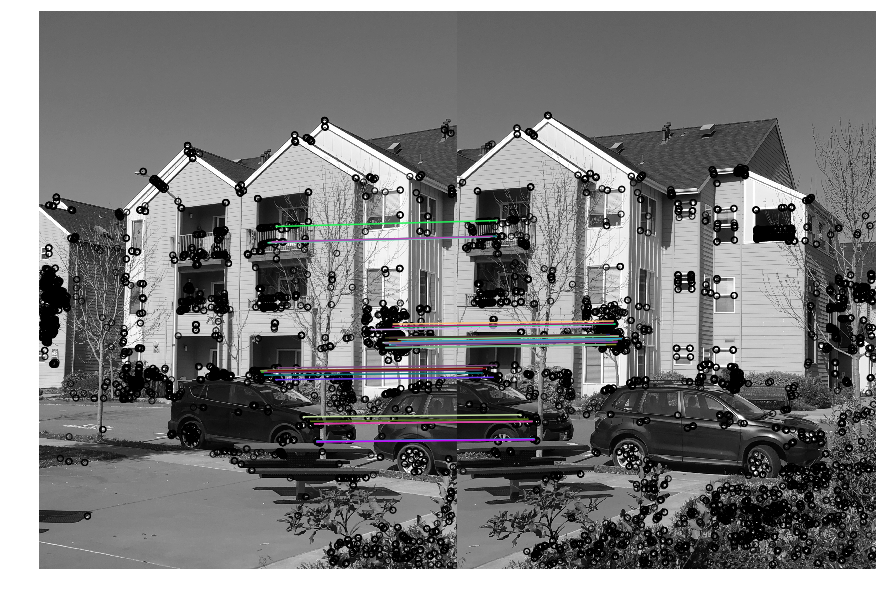

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

### Determine size of final image and warp the outer images to the center image, using the center image as an anchor

In [17]:
# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)



# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0


# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0


# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

## Visualize warped images to make sure they look correct

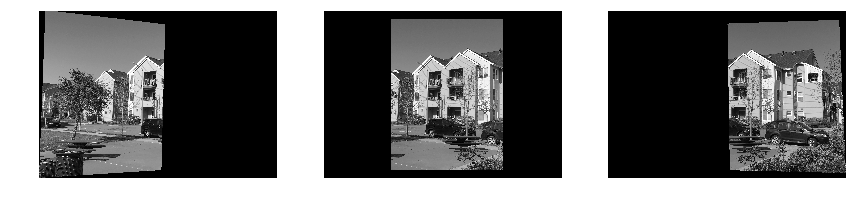

In [18]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

### Combine the images by dividing along the minimum cost path

In [19]:
# Define a cost function

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

### Image 0-1

In [20]:
#define seed points

ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

costs01[0,  :] = 0
costs01[-1, :] = 0

pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

### Visualize the minimum cost path

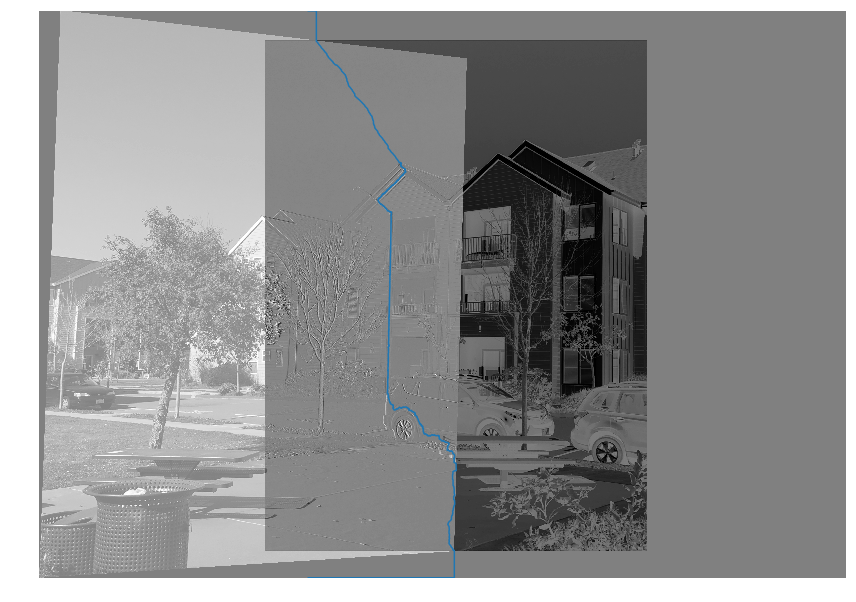

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

### Convert minimum cost path into mask

In [22]:
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

mask0 = (label(mask0, connectivity=1, background=-1) == 1)


### Images 1-2


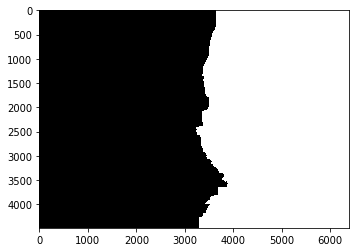

In [23]:

# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

costs12[mask0 > 0] = 1

pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

mask2 = (label(mask2, connectivity=1, background=-1) == 3)



### Visualize

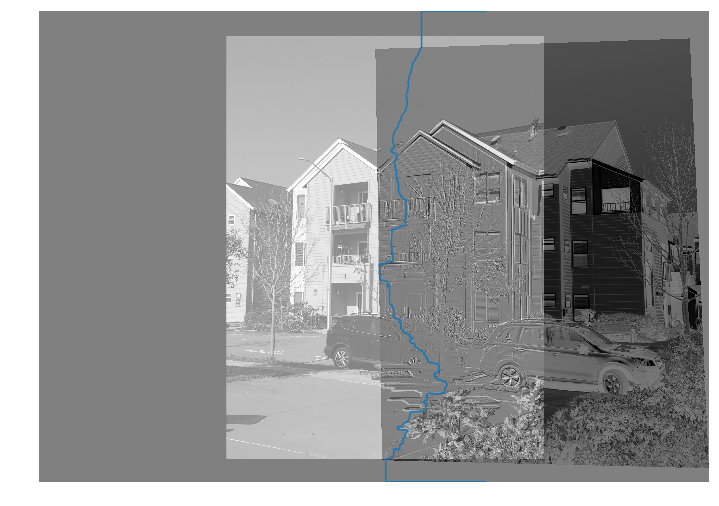

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

### Combine the masks

In [25]:
### Function to help when converting back to color images
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

In [26]:
mask1 = ~(mask0 | mask2).astype(bool)
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)



### Visualize jigsaw images and combined image

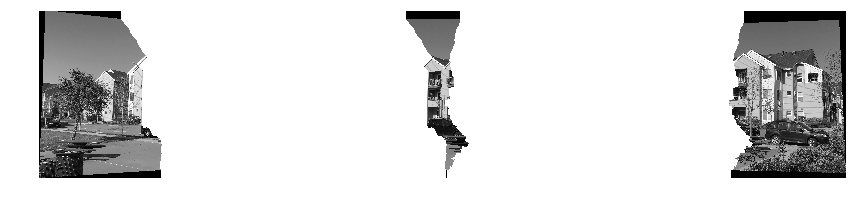

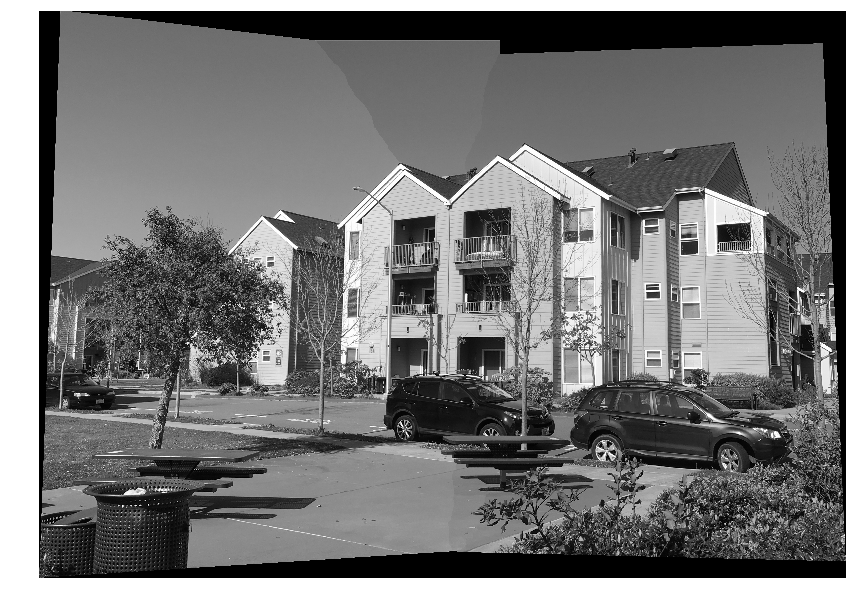

In [27]:
compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

### Convert to color 

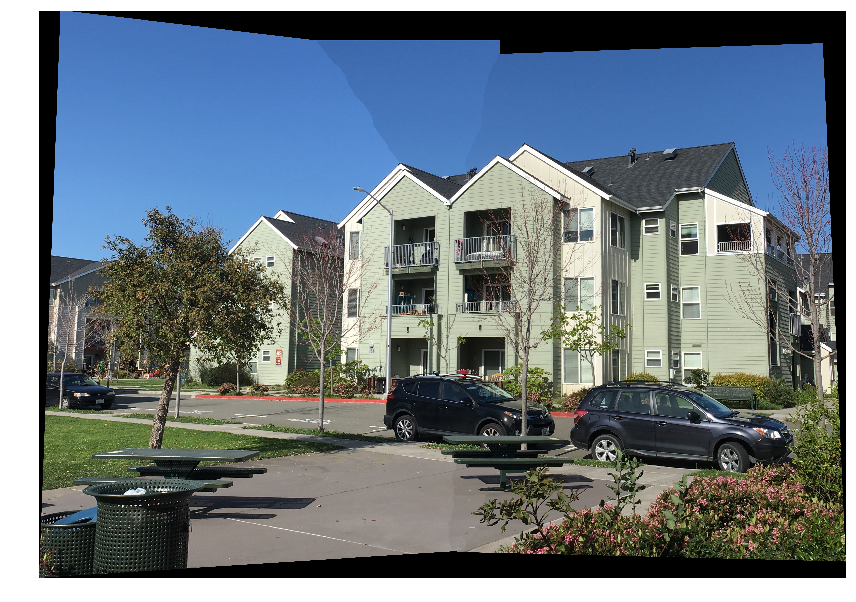

In [28]:
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)


fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

### Save image

In [29]:
# Start with empty image
pano_combined = np.zeros_like(pano0_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano0_color * gray2rgb(mask0)
pano_combined += pano1_color * gray2rgb(mask1)
pano_combined += pano2_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./amazing_panorama.png', pano_combined)

/Users/cwfink/anaconda3/envs/bootcamp-env/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Bonus picture of my daughter

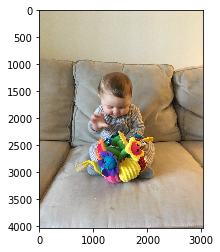

In [31]:
img = plt.imread('3/IMG_2054.JPG')
plt.imshow(img)

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.